In [2]:
import tensorflow as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt

### Utilities

In [3]:
def run_tf(x):
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config) as sess: 
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        out = sess.run(x)

        coord.request_stop()
        coord.join(threads)
        
        return out
    

class FLAGS(object):
    pass

FLAGS.batch_size = 10
FLAGS.data_dir = "/home/sankaran/exercise/ML/TF-Exercise/Tutorials/CIFAR/cifar-10-batches-bin"
FLAGS.num_preprocess_threads = 16
FLAGS.num_classes = 10

def distorted_inputs(data_dir, batch_size, distort=True):
    
    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i) for i in range(1, 6)]
    
    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames,seed=0)
    
    #Create FixedLenthRecord Reader with fixed bytes to read
    record_bytes = 32*32*3+1 #32*32*3 image with 1 byte for label
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    
    key, value = reader.read(filename_queue)
    
    ##Decode
    decoded = tf.decode_raw(value, tf.uint8)
    label = tf.strided_slice(decoded,[0],[1])
    image = tf.strided_slice(decoded,[1],[record_bytes])
    
    
    label = tf.cast(label,tf.int32)
    label = tf.reshape(label,[1])
    image = tf.reshape(image,[3,32,32])
    image = tf.transpose(image,[1,2,0])
    #image = tf.cast(image,tf.float32) ## DESTROYES IMAGE VIS
    
    ##PRE PROCESS
    if(distort):
        image = tf.random_crop(image, [24, 24, 3])
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image,max_delta=0.4)
        image = tf.image.random_contrast(image,lower=0.5,upper=1.8)
    
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                             min_fraction_of_examples_in_queue)
    
    images, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        num_threads=FLAGS.num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size,
        min_after_dequeue=min_queue_examples,
        seed=0)
    
    return [images,label_batch]

In [4]:
def inference(images):
    
    def weight_variable(shape,std=0.1,dtype=tf.float32):
      initializer = tf.truncated_normal_initializer(stddev=std, dtype=dtype)
      return tf.get_variable("Weights",shape,initializer=initializer,dtype=dtype)

    def bias_variable(shape,const=0.0,dtype=tf.float32):
      initializer = tf.constant_initializer(const,dtype)
      return tf.get_variable("biases",shape,initializer=initializer,dtype=dtype)
    
    print("input : ", images)
    
    with tf.variable_scope("conv1"):
        W_conv1 = weight_variable([5, 5, 3, 64])
        b_conv1 = bias_variable([64])

        conv = tf.nn.conv2d(images,W_conv1,strides=[1,1,1,1],padding="SAME")
        h_conv1 = tf.nn.relu(conv + b_conv1)
        
        print("conv 1 : ",h_conv1)
        
    with tf.variable_scope("maxpool1"):
        h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
        
        print("pool 1 : ",h_pool1)
        
    with tf.variable_scope("conv2"):
        W_conv2 = weight_variable([5, 5, 64, 64])
        b_conv2 = bias_variable([64])

        conv = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding="SAME")
        h_conv2 = tf.nn.relu(conv + b_conv2)
        
        print("conv 2 : ",h_conv2)
        
    with tf.variable_scope("maxpool2"):
        h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
        
        print("pool 2 : ",h_pool2)
        
    with tf.variable_scope("Flatten"):
        h_pool2_flat = tf.reshape(h_pool2, [FLAGS.batch_size, -1])
        
        print("flatten : ",h_pool2_flat)
        
    with tf.variable_scope("fc1"):
        W_fc1 = weight_variable([h_pool2_flat.shape[1].value, 384])
        b_fc1 = bias_variable([384])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
        print("fc1 : ",h_fc1)
        
    with tf.variable_scope("fc2"):
        W_fc2 = weight_variable([384, 192])
        b_fc2 = bias_variable([192])
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
        
        print("fc2 : ",h_fc2)
        
    with tf.variable_scope("logit"):
        W_fc3 = weight_variable([192, FLAGS.num_classes])
        b_fc3 = bias_variable([FLAGS.num_classes])
        logit = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
        
        print("logit : ",logit)
        
        return logit

In [5]:
with tf.variable_scope("Input-queue"):
    images,labels = distorted_inputs(FLAGS.data_dir,FLAGS.batch_size)
    
logit = inference(images)

input :  Tensor("Input-queue/shuffle_batch:0", shape=(10, 24, 24, 3), dtype=float32)
conv 1 :  Tensor("conv1/Relu:0", shape=(10, 24, 24, 64), dtype=float32)
pool 1 :  Tensor("maxpool1/MaxPool:0", shape=(10, 12, 12, 64), dtype=float32)
conv 2 :  Tensor("conv2/Relu:0", shape=(10, 12, 12, 64), dtype=float32)
pool 2 :  Tensor("maxpool2/MaxPool:0", shape=(10, 6, 6, 64), dtype=float32)
flatten :  Tensor("Flatten/Reshape:0", shape=(10, 2304), dtype=float32)
fc1 :  Tensor("fc1/Relu:0", shape=(10, 384), dtype=float32)
fc2 :  Tensor("fc2/Relu:0", shape=(10, 192), dtype=float32)
logit :  Tensor("logit/Relu:0", shape=(10, 10), dtype=float32)


In [7]:
out = run_tf(logit)
out

array([[ 3.7050295 ,  0.        ,  1.2130672 ,  0.22528875,  5.1103187 ,
         0.        ,  0.43403953,  0.        ,  5.7027917 ,  0.        ],
       [ 4.691639  ,  0.        ,  4.3102665 ,  0.        ,  8.06484   ,
         0.        ,  0.11986804,  0.        , 10.907906  ,  0.        ],
       [ 1.7223086 ,  0.        ,  0.        ,  0.        ,  2.2410486 ,
         0.        ,  3.3296764 ,  0.        ,  4.1415834 ,  0.        ],
       [ 4.678101  ,  0.        ,  2.9157789 ,  0.        ,  7.0115767 ,
         0.        ,  1.1772975 ,  0.        ,  9.165938  ,  0.        ],
       [ 3.6860223 ,  0.        ,  2.8508024 ,  0.        ,  4.814333  ,
         0.        ,  0.41808775,  0.        ,  7.444767  ,  0.        ],
       [ 5.5728664 ,  0.        ,  1.952989  ,  0.        ,  7.702625  ,
         0.        ,  0.6654564 ,  0.        , 12.101912  ,  0.        ],
       [ 6.1383314 ,  0.        ,  4.673526  ,  0.        , 10.266353  ,
         0.        ,  1.5503895 ,  0.        

### Loss function

In [8]:
def loss(logit,lables):
    
    with tf.variable_scope("cross-entropy"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(labels,[FLAGS.num_classes]), logits=logit)
        avg_cross_entropy = tf.reduce_mean(cross_entropy)

### Training

**DECAYING LEARNING RATE**

**tf.train.exponential_decay**

Reduces learning rate exponentially every **decay_steps**

decayed_learning_rate = learning_rate X decay_rate ^ (global_step / decay_steps)


In [34]:
lr = tf.train.exponential_decay(learning_rate=0.01,global_step=10,decay_steps=100,decay_rate=0.1)
tf.Session().run(lr)

0.007943282

In [16]:
lr = tf.train.exponential_decay(0.01,100,100,0.1)
tf.Session().run(lr)

0.001

In [17]:
lr = tf.train.exponential_decay(0.01,200,100,0.1)
tf.Session().run(lr)

0.000100000005

In [29]:
e = []
for i in range(1000):
    e.append(tf.train.exponential_decay(0.1,i,200,0.01))
e_lr = tf.Session().run(e)

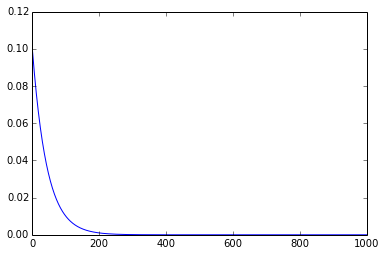

In [30]:
plt.plot(e_lr)

**tf.train.ExponentialMovingAverage**

In [166]:
em = tf.train.ExponentialMovingAverage(0.9)

In [167]:
a = tf.Variable(5.)
y = 5.

In [168]:
em.apply([a])
x = em.average(a)

In [169]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(a.assign(y))
    xl = sess.run(x)

In [170]:
xl

5.0

In [165]:
y=6.

In [181]:

w = tf.Variable(0, dtype=tf.float32)
ema = tf.train.ExponentialMovingAverage(decay=0.01)
m = ema.apply([w])
av = ema.average(w)

x = tf.placeholder(tf.float32, [None])
y = tf.placeholder(tf.float32, [None])
y_ = tf.multiply(x, w)

with tf.control_dependencies([m]):
    loss = tf.reduce_sum(tf.square(tf.subtract(y, y_)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        _, w_, av_ = sess.run([train, w, av], feed_dict={x: [1], y: [10]})
        print(w_, ',', av_)

0.0 , 0.0
0.020000001 , 0.019800002
0.03996 , 0.019800002
0.05988008 , 0.0397584
0.07976032 , 0.059678867
0.0996008 , 0.079559505
0.1194016 , 0.119201586
0.1391628 , 0.13896318
0.15888447 , 0.13896318
0.1785667 , 0.15868525
0.19820955 , 0.17836788
0.21781313 , 0.19801113
0.23737751 , 0.21761511
0.25690275 , 0.23717989
0.27638894 , 0.25670552
0.29583618 , 0.2761921
0.3152445 , 0.29563975
0.334614 , 0.31504846
0.35394478 , 0.3537495
0.3732369 , 0.3537495
0.39249042 , 0.39229593
0.41170543 , 0.39229593
0.43088204 , 0.41151133
0.45002028 , 0.43068832
0.46912023 , 0.44982696
0.488182 , 0.4689273
0.50720567 , 0.48798946
0.52619123 , 0.5070135
0.54513884 , 0.5259994
0.5640485 , 0.54494745
0.58292043 , 0.5638575
0.6017546 , 0.5827298
0.6205511 , 0.60156435
0.63931 , 0.62036127
0.6580314 , 0.6391205
0.6767153 , 0.6578423
0.6953619 , 0.6765266
0.7139712 , 0.69517356
0.73254323 , 0.73235565
0.7510781 , 0.73235565
0.76957595 , 0.7508909
0.7880368 , 0.7693891
0.80646074 , 0.7878503
0.8248478 , 0.80

In [196]:
w = tf.Variable(0, dtype=tf.float32)
ema = tf.train.ExponentialMovingAverage(decay=0.01)
m = ema.apply([w])
av = ema.average(w)

li = tf.range(0,50,dtype=tf.float32)
i_ = tf.Variable(0)
with tf.control_dependencies([m]):
    ic = i_.assign_add(1)
    c = w.assign(li[i_])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        _,w_,av_ = sess.run([ic,c,av])
        print(w_,av_)

0.0 0.0
1.0 0.0
3.0 0.0
3.0 0.99
4.0 2.9799
6.0 2.999799
6.0 3.9899979
7.0 5.9799
9.0 5.999799
9.0 6.989998
10.0 8.9799
11.0 8.999799
12.0 9.989998
14.0 10.9899
14.0 13.979899
15.0 13.979899
16.0 13.999799
17.0 14.989998
18.0 15.9899
19.0 16.989899
21.0 17.989899
21.0 20.979898
22.0 20.9998
23.0 20.9998
25.0 21.989998
25.0 22.9899
26.0 24.979898
28.0 24.9998
29.0 25.989998
29.0 27.9799
30.0 28.999899
31.0 29.99
32.0 29.99
33.0 31.989899
34.0 31.989899
35.0 33.9899
36.0 33.9899
37.0 34.9899
38.0 35.9899
39.0 36.9899
40.0 37.9899
41.0 38.9899
43.0 39.9899
44.0 40.9899
44.0 43.9898
45.0 43.9898
46.0 43.999897
47.0 44.989998
48.0 45.9899
49.0 46.9899


In [187]:
i_ = tf.constant(0)

In [188]:
i_+1

<tf.Tensor 'add_1:0' shape=() dtype=int32>